In this dataset each sentence is pharsed into its tree structure and each node is assigned a fine-grained sentiment label ranging from 0 − 4.

**Structure** 
*   PharseId
*   SentenceId
*   Pharse
*   Sentiment


**Sentiment repersentation**
*   0 -- Very Negative
*   1 -- Negative
*   2 -- Neutral
*   3 -- Positive
*   4 -- Very Positive



In [0]:
# train data of Rotten Tomatoes movie reviews
# !wget https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv

In [2]:
# import libraries we need
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from string import punctuation

# url of the dataset
url="https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Read the dataset
dataset = pd.read_csv(url, header=0, delimiter="\t", quoting=3)

# Show the first ten rows of the dataset
dataset.head(5)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
# retrive full sentences
def retrive_full_sentence(df):
  num_sentences=df["SentenceId"].max()
  full_sentences=[]
  num_full_sentences=0
  for i in range(df.shape[0]):
    if df['SentenceId'][i] > num_full_sentences:
      full_sentences.append((df['Phrase'][i], df['Sentiment'][i]))
      num_full_sentences = num_full_sentences + 1
  full_sentences_df=pd.DataFrame(full_sentences, columns=['Phrase', 'Sentiment'])    
  return full_sentences_df

In [0]:
fullsens=retrive_full_sentence(dataset)
# X_sentences=fullsens['Phrase']
# Y_sentences=fullsens['Sentiment']

X=dataset["Phrase"]
Y=dataset["Sentiment"]


In [0]:
# Convert dataset to np array
# Use only full sentences.
# X_sentences=np.array(X_sentences)
# Y=np.array(Y_sentences)

# Use all data.
X=np.array(X)
Y=np.array(Y)

In [0]:
# clean text, remove stopwords, puncuation, and lemmatizing
def clean_text(df):
  clean_phrase=[]
  for n in range(len(df)):
    phrases=str(df[n])
    # remove puncuation
    phrases=re.sub('[^a-zA-Z]',' ',phrases).lower().split()
    # lemmatizing , remove stopwords
    phrases=[WordNetLemmatizer().lemmatize(phrase) for phrase in phrases if not phrase in stopwords.words('english')]
    use_words=' '.join(phrases)
    clean_phrase.append(use_words)
  return clean_phrase

In [0]:
# Clean data this process may takes a few minutes
# if use only full sentences
# data_X=clean_text(X_sentences)

# use all sentences
data_X=clean_text(X)

In [9]:
data_X[0:100]

['series escapade demonstrating adage good goose also good gander occasionally amuses none amount much story',
 'series escapade demonstrating adage good goose',
 'series',
 '',
 'series',
 'escapade demonstrating adage good goose',
 '',
 'escapade demonstrating adage good goose',
 'escapade',
 'demonstrating adage good goose',
 'demonstrating adage',
 'demonstrating',
 'adage',
 '',
 'adage',
 'good goose',
 '',
 'good goose',
 '',
 'good goose',
 '',
 'good goose',
 'good',
 'goose',
 '',
 'goose',
 'goose',
 'also good gander occasionally amuses none amount much story',
 'also good gander occasionally amuses none amount much story',
 'also',
 'also',
 'good gander occasionally amuses none amount much story',
 'gander occasionally amuses none amount much story',
 'gander occasionally amuses none amount much story',
 'gander',
 'gander',
 'gander',
 '',
 'occasionally amuses none amount much story',
 '',
 '',
 '',
 '',
 'occasionally amuses none amount much story',
 'occasionally',
 '

Data Set
1.   Training set/Test set = 70:30 
2.   Random state is set to 2003





In [0]:
# create TF-IDF
x_train, x_test, y_train, y_test = train_test_split(data_X, Y, test_size=0.3, random_state=2003)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weights = dict(enumerate(class_weights))

# if use all sentences
max_feature = 3500
vectorizer = TfidfVectorizer(max_features=max_feature, min_df=4, max_df=0.8, ngram_range=(1,1))

x_train = vectorizer.fit_transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

# x_train = vectorizer.fit_transform(x_train).toarray()
# x_test = vectorizer.fit_transform(x_test).toarray()

In [11]:
import keras
from keras import utils

# convert to one-hot vetctor for keras 
# calculate Crossentroyloss "categorical_crossentropy"
y_train = utils.to_categorical(y_train, 5)
y_test = utils.to_categorical(y_test, 5)

Using TensorFlow backend.


In [12]:
# len(vectorizer.get_feature_names())
x_train.shape[0]

109242

In [0]:
# Convoluation layer expecte 3dim input
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [14]:
x_train.shape[1]

3500

## The Convolutional model

A text-based movie review mutil-class sentiment anlaysis,the model is still
a 1D Convoluational

In [0]:
from keras.models import Model
from keras.models import Sequential
# from keras.layers import Input
from keras.layers import Dense, Activation, Flatten, Dropout, Conv1D, MaxPooling1D
from keras.layers import Embedding
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
 

In [0]:
# define our evaluation metrices, recall, precision, f1 = 2*((precision*recall)/(precision+recall))
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Model_1 with single convoluation layer.

In [17]:
model = Sequential(name='cnnClassifier')
model.add(Conv1D(256,4,padding='same',activation='relu',strides=1,
                 input_shape = (x_train.shape[1],1), name='conv1d_0'))
model.add(Conv1D(256, 4, padding='same', activation='relu', name='conv1d_1'))
model.add(MaxPooling1D(2, name='maxpooling1d_0'))
model.add(Dropout(0.2, name='dropout'))
model.add(Conv1D(128, 4, padding='same', activation='relu', name='conv1d_2'))
model.add(Conv1D(128, 4, padding='same', activation='relu', name='conv1d_3'))
model.add(MaxPooling1D(4, name='maxpooling1d_1'))
model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu', name='dense_0'))
model.add(Dense(64, activation='relu', name='dense_1'))
model.add(Dense(5, activation='softmax', name='dense_2'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.summary()

Model: "cnnClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_0 (Conv1D)            (None, 3500, 256)         1280      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3500, 256)         262400    
_________________________________________________________________
maxpooling1d_0 (MaxPooling1D (None, 1750, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1750, 256)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1750, 128)         131200    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1750, 128)         65664     
_________________________________________________________________
maxpooling1d_1 (MaxPooling1D (None, 437, 128)        

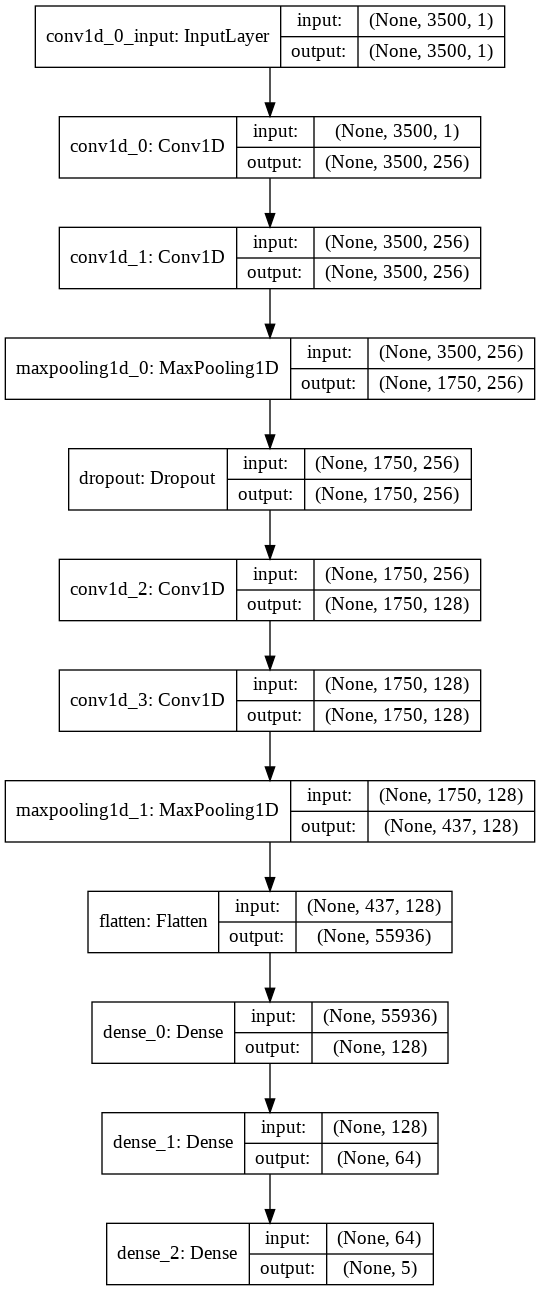

In [19]:
plot_model(model, 'model.png',show_shapes=True)

Define our evaluation method.

In [20]:
# accuracy = "categorical_accuracy"
model.compile(optimizer='adam', 
        loss='categorical_crossentropy',
        metrics=['accuracy', recall_m, precision_m, f1_m])

In [21]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5,
              patience=7, verbose=0, mode='auto', restore_best_weights=True)


# Save the best model
# monitor = [EarlyStopping(monitor='val_loss', min_delta=1e-5,
#             patience=5, verbose=0, mode='auto', restore_best_weights=True),
#              ModelCheckpoint(filepath='1094314_1dconv_classifier.h5', monitor='val_loss', save_best_only=True)]

history=model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[monitor], validation_data=(x_test,y_test), class_weight=class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 109242 samples, validate on 46818 samples
Epoch 1/20





109242/109242 [==============================] - 205s 2ms/step - loss: 1.0973 - acc: 0.5627 - recall_m: 0.3865 - precision_m: 0.6500 - f1_m: 0.4801 - val_loss: 0.9985 - val_acc: 0.6032 - val_recall_m: 0.4864 - val_precision_m: 0.6706 - val_f1_m: 0.5634
Epoch 2/20
109242/109242 [==============================] - 201s 2ms/step - loss: 0.9351 - acc: 0.6293 - recall_m: 0.5222 - precision_m: 0.6893 - f1_m: 0.5935 - val_loss: 0.9489 - val_acc: 0.6213 - val_recall_m: 0.5232 - val_precision_m: 0.6727 - val_f1_m: 0.5882
Epoch 3/20
109242/109242 [==============================] - 200s 2ms/step - loss: 0.8543 - acc: 0.6638 - recall_m: 0.5894 - precision_m: 0.7048 - f1_m: 0.6416 - val_loss: 0.9414 - val_acc: 0.6306 - val_recall_m: 0.5390 - val_precision_m: 0.6729 - val_f1_m: 0.5982
Epoch 4/20
109242/109242 [=============================

##Saving model and model weights

HDF5 file will contain:
* the architecture of the model, allowing to re-create the model
* the weights of the model
* the training configuration (loss, optimizer)
* the state of the optimizer, allowing to resume training exactly where you left off

In [0]:
# we can only save the 
model.save('1094314_1dconv_classifier.h5')
model.save_weights('weights_1094314_1dconv_classifier.h5')

##Loading model and weights

In [0]:
from keras.models import load_model
# load model and custom metrics

model = load_model('1094314_1dconv_classifier.h5',
          custom_objects={
              'recall_m': recall_m,
              'precision_m': precision_m,
              'f1_m': f1_m})
model.load_weights('weights_1094314_1dconv_classifier.h5')

#Testing(also validated during training)

In [24]:
evaluate = model.evaluate(x_test, y_test, batch_size=128)
print('Test accuracy: ',evaluate[1])
print('Test recall: ',evaluate[2])
print('Test precision: ',evaluate[3])
print('Test f1: ', evaluate[4])

46818/46818 [==============================] - 24s 521us/step
Test accuracy:  0.6362082959367238
Test recall:  0.5610662565578017
Test precision:  0.6739654593773463
Test f1:  0.6120970700138417


#Training testing Visualization

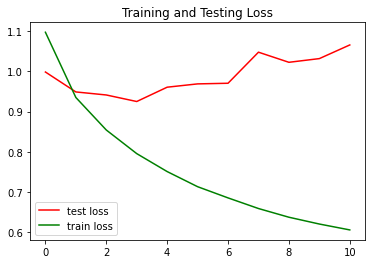

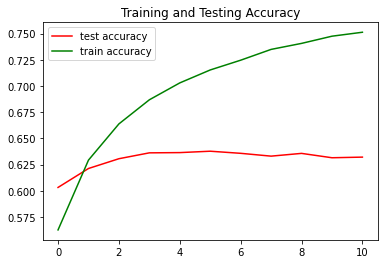

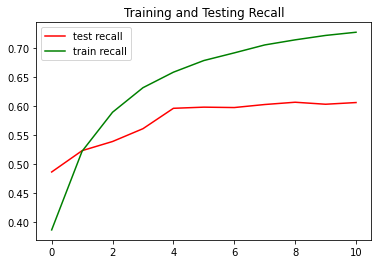

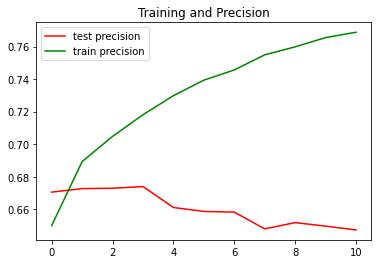

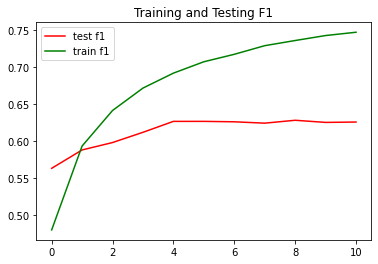

In [25]:
epochs=monitor.stopped_epoch
x=range(0,epochs+1)
test_loss=history.history['val_loss']
train_loss=history.history['loss']
test_acc=history.history['val_acc']
train_acc=history.history['acc']
test_recall=history.history['val_recall_m']
train_recall=history.history['recall_m']
test_precision=history.history['val_precision_m']
train_precision=history.history['precision_m']
test_f1=history.history['val_f1_m']
train_f1=history.history['f1_m']

plt.plot(x, test_loss,'r')
plt.plot(x, train_loss,'g')
plt.title('Training and Testing Loss')
plt.legend(['test loss', 'train loss'])

plt.figure()
plt.plot(x, test_acc, 'r')
plt.plot(x, train_acc, 'g')
plt.title('Training and Testing Accuracy')
plt.legend(['test accuracy', 'train accuracy'])

plt.figure()
plt.plot(x, test_recall, 'r')
plt.plot(x, train_recall, 'g')
plt.title('Training and Testing Recall')
plt.legend(['test recall', 'train recall'])

plt.figure()
plt.plot(x, test_precision, 'r')
plt.plot(x, train_precision, 'g')
plt.title('Training and Precision')
plt.legend(['test precision', 'train precision'])

plt.figure()
plt.plot(x, test_f1, 'r')
plt.plot(x, train_f1, 'g')
plt.title('Training and Testing F1')
plt.legend(['test f1', 'train f1'])